In [1]:
import pandas as pd
import numpy as np
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import praw
import os
import json
from collections import defaultdict
import time
import matplotlib.pyplot as plt 

In [2]:
SCOPE = [
    # Used to send and retrieve data to and from Google Sheets
    "https://spreadsheets.google.com/feeds",
    'https://www.googleapis.com/auth/spreadsheets',
    "https://www.googleapis.com/auth/drive.file",
    "https://www.googleapis.com/auth/drive",
]

In [3]:
creds = ServiceAccountCredentials.from_json_keyfile_name(os.path.join("../config", 
                                                                      "google_sheets_creds.json"
                                                                     ), SCOPE)

client = gspread.authorize(creds)

In [4]:
conf_path = os.path.join('../config', 'conf.json')
with open(conf_path, "r") as conf_file:
    config_data = json.loads(conf_file.read())

reddit = praw.Reddit(
    # Creating Reddit object
    client_id=config_data["client_id"],
    client_secret=config_data["client_secret"],
    user_agent="DSC180B capstone project",
)

In [5]:
submission_data_worksheet = client.open("database").worksheet('submission_data')

In [6]:
sumbission_data_df  = pd.DataFrame(submission_data_worksheet.get_all_records())

In [7]:
sumbission_data_df["Is Misinformation"].value_counts()

Undetected    69290
Detected        508
Name: Is Misinformation, dtype: int64

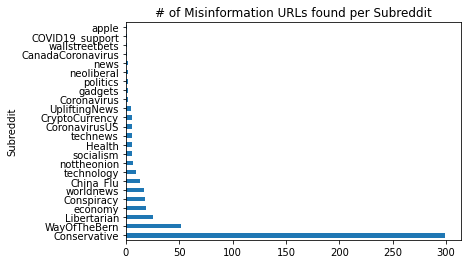

In [8]:
mis_info_posts = sumbission_data_df.loc[sumbission_data_df["Is Misinformation"] == "Detected"].reset_index(drop=True)

curr_fig = mis_info_posts["Subreddit"].value_counts(
).plot(kind="barh", 
       ylabel="# of Misinformation Links Detected", 
       xlabel="Subreddit", 
       title="# of Misinformation URLs found per Subreddit").get_figure()

curr_fig.savefig("# of Misinformation URLs found per Subreddit", bbox_inches='tight')
plt.show()

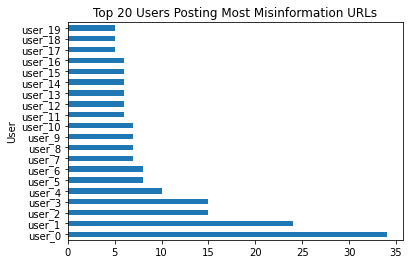

In [9]:
users_to_analyze = 20

top_authors = mis_info_posts["Author"].value_counts().iloc[1:users_to_analyze+1]
old_index = top_authors.index
user_fake_names = {}
new_index = []
for index, user in enumerate(top_authors.index):
    # Using fake names for the anonimity
    user_fake_names[user] = f"user_{index}"
    new_index.append(f"user_{index}")

top_authors.index = new_index
curr_fig = top_authors.plot(kind="barh", 
                title=f"Top {users_to_analyze} Users Posting Most Misinformation URLs",
                xlabel="User",
                ylabel="# of Misinformation URLs").get_figure()

curr_fig.savefig(f"Top {users_to_analyze} Users Posting Most Misinformation URLs", bbox_inches='tight')

In [10]:
top_authors.index = old_index

In [11]:
comment_limit = 200
sleep_time = 5
subreddit_of_comments_per_user = defaultdict(set)

for user_name in top_authors.index:
    user = reddit.redditor(user_name)
    user_data = user._fetch_data()
    try:
        user_karma_total = user_data["data"]["total_karma"]
        user_comment_karma = user_data["data"]["comment_karma"]
    except KeyError as e:
        print(user_fake_names[user_name], e)
    #user_submissions = user.submissions()
    user_comments_itter = user.comments.hot(limit=comment_limit)
    
    try:
        for comment in user_comments_itter:
            subreddit_of_comment = comment.subreddit.display_name
            subreddit_of_comments_per_user[user_name].add(subreddit_of_comment)
    except Exception as e:
        print(user_fake_names[user_name], e)
    
    print(f"Got subreddits of last {comment_limit} comments from user: {user_fake_names[user_name]}")
    time.sleep(sleep_time)

Got subreddits of last 200 comments from user: user_0
Got subreddits of last 200 comments from user: user_1
Got subreddits of last 200 comments from user: user_2
Got subreddits of last 200 comments from user: user_3
Got subreddits of last 200 comments from user: user_4
Got subreddits of last 200 comments from user: user_5
Got subreddits of last 200 comments from user: user_6
Got subreddits of last 200 comments from user: user_7
Got subreddits of last 200 comments from user: user_8
Got subreddits of last 200 comments from user: user_9
Got subreddits of last 200 comments from user: user_10
Got subreddits of last 200 comments from user: user_11
Got subreddits of last 200 comments from user: user_12
Got subreddits of last 200 comments from user: user_13
Got subreddits of last 200 comments from user: user_14
Got subreddits of last 200 comments from user: user_15
Got subreddits of last 200 comments from user: user_16
Got subreddits of last 200 comments from user: user_17
Got subreddits of la

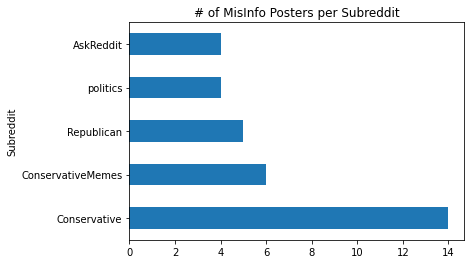

In [12]:
subreddits_most_common = defaultdict(int)
for user, subreddits in subreddit_of_comments_per_user.items():
    for subreddit in subreddits:
        subreddits_most_common[subreddit] += 1
        
curr_fig = pd.Series(subreddits_most_common).sort_values(ascending=False).iloc[:5].plot(kind="barh",
                                                                             title="# of MisInfo Posters per Subreddit",
                                                                             ylabel="# of MisInfo Posters",
                                                                             xlabel="Subreddit"
                                                                            ).get_figure()

curr_fig.savefig("# of MisInfo Posters per Subreddit", bbox_inches='tight')

In [28]:
curr_fig = pd.Series(subreddits_most_common).sort_values(ascending=False).iloc[:24].sort_values(ascending=True)
curr_fig = pd.DataFrame(curr_fig).reset_index()
curr_fig.columns = ["Subreddit", "# of MisInfo Posters"]
curr_fig.head()

,Subreddit,# of MisInfo Posters
0,4chan,2
1,Coronavirus,2
2,cars,2
3,wallstreetbets,2
4,LetsGoBrandon,2


In [30]:
# Uploads user data to user_data worksheet on google sheets

#user_data_worksheet = client.open("database").worksheet('user_data')
#user_data_worksheet.update([curr_fig.columns.values.tolist()] + curr_fig.values.tolist(), value_input_option='USER_ENTERED')